##### Programmer : Ovadia Ronen
# Final Project 
## weekly anomaly prediction along with daily amomaly detector 
### buisness case : monitor on a critical paramenter, that may hazard the patient 
#### this module will be part of the monitoring system

#### Determining Anomaly Level:

- Anomaly level will be determined by the business, ensure clear criteria are defined for what constitutes an anomaly.
- Consider incorporating domain expertise and historical data analysis to set appropriate thresholds for anomaly detection.
- Define the acceptable range or limits for each sensor parameter and identify when values approach or exceed those limits.

#### Tracking Values Close to Limits:

- Implement monitoring mechanisms to track sensor values that are approaching the predefined limits.
- Continuously compare the current sensor values to the limit thresholds and generate alerts or notifications when values are close to the limits.
- Include historical context and trends to identify if values are consistently moving towards the limits over time.

#### Prediction Model for Future Values:

- Train a prediction model using historical and aggregated data to forecast future values of sensor parameters.
- Use the prediction model to estimate if the future values may exceed the predefined limits.
- Incorporate the prediction results into the anomaly detection process to enhance proactive identification of potential anomalies.

#### Visualization and Alerting:

- Design the user interface (UI) to visualize sensor data, historical trends, and predicted values.
- Highlight data points and trends that are approaching or exceeding the predefined limits.
- Implement alerting mechanisms within the UI to notify users when anomalies or potential limit breaches are detected.


# Coding

In [12]:
!pip install -q xlrd
!pip install -q flask
!pip install -q gunicorn
!pip install -q hdfs
!pip install -q flask
!pip install -q gunicorn
!pip install -q sqlalchemy
!pip install -q pandas 
!pip install -q pyodbc
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn



In [13]:
#modules to be used
import pandas as pd
import numpy as np

from datetime import datetime as dt
from datetime import timedelta as td

import urllib 
import urllib.parse

import sqlalchemy as sa
from sqlalchemy import text
import sqlalchemy as sa
from sqlalchemy.sql import text
from sqlalchemy.exc import OperationalError 
from sqlalchemy.exc import SQLAlchemyError

import pyodbc

import time

import glob
import csv
import os

from hdfs import InsecureClient
import xlrd

from flask import Flask, request, jsonify
import urllib 
import json

import pickle
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
import seaborn as sns



## Batch Processing and Analysis:

#### Batch Data Processing:
- fetch Sealing Json Data
- Read sensor measuring data from various sources every 15 seconds.
- Publish the data to Kafka topics.
- Retrieve historical data from the data store.
- Aggregate data based on desired time intervals (e.g., daily, weekly).
- Perform statistical analysis and identify anomaly thresholds based on historical patterns and business rules.
- Generate predicted values for the parameters using prediction models.
- Store the aggregated data, anomaly thresholds, and predicted values in the data store.


In [63]:
#configs_id for sealingcell is '917'
def fetch_sealing_data(year, quarter=None, month=None, yearweek=None, weekday=None, configs_id=917):
    # SQL server connection
    params = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                     "SERVER=LTD-BRAVO;"
                                     "DATABASE=CQCAnalyzer;"
                                     "UID=ovadir2;"
                                     "PWD=1qaz!2wsx@")

    engine = sa.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params))
    _filter =''
    if quarter:
        _filter = f' AND quarter = {quarter}'
        
    else:
        if month: #overwrite quarter
            _filter = f' AND month = {month}'
        else:
            if yearweek:  #overwrite month
                _filter = f' AND week = {yearweek}'
            if weekday:  #add day in week
                    _filter += f' AND dayweek = {weekday}'
         
    #print(f'filter is: {_filter}')
    try:
        with engine.connect() as con:
  
            fquery1 = (f"""WITH CTE AS ( SELECT B.BatchID, B.BatchName, B.BatchPath, B.ConfigID, B.Shift, B.Cell_Name, B.TestTypeID,
                                   B.LastInsertedRow, B.StartTime, B.Heads, B.BatteryTypeID, B.BodyTypeID, B.DomeTypeID,
                                   B.PCATypeID, B.PCBTypeID, B.PlacementContractorID, B.EmployeID, B.OpticsTypeID,
                                   B.Versions, B.LotNumber, B.SubLot, TP.TestID, TP.Capsule_Number,
                                   TP.Initial_Capsule_Id_HEX, TP.Capsule_Id_HEX, TP.Test_Counter, TP.ERROR_Code_Number,
                                   TP.Capsule_Id, TP.PASS_FAILED, TP.Start_Time, TP.End_time, TP.Test_Time_min, TP.Date,
                                   TP.History, TP.Remark, TP.Blister_Id, TP.Fail_Tray, TP.Fail_capsule_position,
                                   TP.ERROR_Code_Description, TP.WTC, TP.CQC_num, TP.Capsule_Counter, TP.Cell_Name AS TP_Cell_Name,
                                   SC.DomeCaseGap, SC.LaserPower, SC.StitchArea, SC.MinStitchWidth, SC.LeakTest,
                                   DATEPART(YEAR, CONVERT(DATE, TP.Date, 103)) AS year,
                                   DATEPART(QQ, CONVERT(DATE, TP.Date, 103)) AS quarter,
                                   DATEPART(WEEK, CONVERT(DATE, TP.Date, 103)) AS week,
                                   DATEPART(MONTH, CONVERT(DATE, TP.Date, 103)) AS month,
                                   DATEPART(DW, CONVERT(DATE, TP.Date, 103)) AS dayweek 
                                    FROM dbo.Batch AS B
                                    JOIN dbo.TestProperty AS TP ON B.BatchID = TP.BatchID
                                    JOIN SealingCell AS SC ON TP.TestID = SC.TestID
                                    WHERE B.ConfigID = {configs_id} )
            
                                    SELECT CTE.*,
                                           CTE.DomeCaseGap AS DomeCaseGap_spc_orig,
                                           CTE.LaserPower AS LaserPower_spc_orig,
                                           CTE.MinStitchWidth AS MinStitchWidth_spc_orig,
                                           CTE.StitchArea AS StitchArea_spc_orig,
                                           CTE.LeakTest AS LeakTest_spc_orig,
                                           CONCAT((CTE.DomeCaseGap * 0.8), ':', (CTE.DomeCaseGap * 1.2)) AS DomeCaseGap_spc,
                                           CONCAT((CTE.LaserPower * 0.8), ':', (CTE.LaserPower * 1.2)) AS LaserPower_spc,
                                           CONCAT((CTE.MinStitchWidth * 0.8), ':', (CTE.MinStitchWidth * 1.2)) AS MinStitchWidth_spc,
                                           CONCAT((CTE.StitchArea * 0.8), ':', (CTE.StitchArea * 1.2)) AS StitchArea_spc,
                                           CONCAT((CTE.LeakTest * 0.8), ':', (CTE.LeakTest * 1.2)) AS LeakTest_spc,
                                           limits.*
                                    FROM CTE
                                    CROSS APPLY ( SELECT scl.BatchId,
                                                 scl.DomeCaseGap AS DomeCaseGap_limit,
                                                 scl.LaserPower AS LaserPower_limit,
                                                 scl.MinStitchWidth AS MinStitchWidth_limit,
                                                 scl.StitchArea AS StitchArea_limit,
                                                 scl.LeakTest AS LeakTest_limit
                                        FROM dbo.SealingCellLimits AS scl
                                        WHERE scl.BatchId = CTE.BatchID) AS limits
                                    WHERE year = {year} {_filter} ;""")
            
            df = pd.read_sql(text(fquery1), con)
             

            # print('=======================================')
            # print(' LTD_BRAVO stations data......completed')
            # print('=======================================')
            return df

    except (sa.exc.SQLAlchemyError, sa.exc.OperationalError , pyodbc.OperationalError) as error:
        print(f"Error connecting to SQL Server Bravo: {error}")
        return pd.DataFrame()
                                              


In [64]:
#sealing cell data (scd)
scd_raw = fetch_sealing_data(year=2022, quarter=None, month=None, yearweek=None, weekday=None, configs_id=917)
display(scd_raw)

,BatchID,BatchName,BatchPath,ConfigID,Shift,Cell_Name,TestTypeID,LastInsertedRow,StartTime,Heads,BatteryTypeID,BodyTypeID,DomeTypeID,PCATypeID,PCBTypeID,PlacementContractorID,EmployeID,OpticsTypeID,Versions,LotNumber,SubLot,TestID,Capsule_Number,Initial_Capsule_Id_HEX,Capsule_Id_HEX,Test_Counter,ERROR_Code_Number,Capsule_Id,PASS_FAILED,Start_Time,End_time,Test_Time_min,Date,History,Remark,Blister_Id,Fail_Tray,Fail_capsule_position,ERROR_Code_Description,WTC,CQC_num,Capsule_Counter,TP_Cell_Name,DomeCaseGap,LaserPower,StitchArea,MinStitchWidth,LeakTest,year,quarter,week,month,dayweek,DomeCaseGap_spc_orig,LaserPower_spc_orig,MinStitchWidth_spc_orig,StitchArea_spc_orig,LeakTest_spc_orig,DomeCaseGap_spc,LaserPower_spc,MinStitchWidth_spc,StitchArea_spc,LeakTest_spc,BatchId,DomeCaseGap_limit,LaserPower_limit,MinStitchWidth_limit,StitchArea_limit,LeakTest_limit
0,914959.0,230101_SB3-AFR-U_SealingCell_TEST_58735U_MX_92...,\\matrix\cqcbackup2023\SB3_SealingCell\SB3\230...,917,S2,None,1,None,2023-01-01 11:54:01.783,1,None,None,None,None,None,None,267.0,None,2.6.0.6::1.0.1.2::12/18/2019::11.9999::14.00::...,58735U,None,29536264.0,None,None,None,208818.0,1009;,None,Error,11:52:21 AM,11:54:01 AM,01:39,01/01/2023,None,sqa,MLETTF5,None,0,No capsule in postion timeout;,None,None,None,11.0,NaN,None,NaN,None,None,2023,1,1,1,1,NaN,None,None,NaN,None,:,:,:,:,:,914959.0,None,None,None,None,None
1,914959.0,230101_SB3-AFR-U_SealingCell_TEST_58735U_MX_92...,\\matrix\cqcbackup2023\SB3_SealingCell\SB3\230...,917,S2,None,1,None,2023-01-01 11:54:01.783,1,None,None,None,None,None,None,267.0,None,2.6.0.6::1.0.1.2::12/18/2019::11.9999::14.00::...,58735U,None,29536304.0,None,None,None,208819.0,1009;,None,Error,11:59:24 AM,12:01:19 PM,01:55,01/01/2023,None,sqa,MLETTF5,None,0,No capsule in postion timeout;,None,None,None,11.0,NaN,None,NaN,None,None,2023,1,1,1,1,NaN,None,None,NaN,None,:,:,:,:,:,914959.0,None,None,None,None,None
2,914974.0,230101_SB3-AFR-U_SealingCell_FTEST_58735U_MX_9...,\\matrix\cqcbackup2023\SB3_SealingCell\SB3\230...,917,S2,None,2,None,2023-01-01 14:17:12.633,1,None,None,None,None,None,None,267.0,None,2.6.0.6::1.0.1.2::12/18/2019::11.9999::14.00::...,58735U,None,29536783.0,None,None,None,553072.0,1009;,None,Error,02:15:33 PM,02:17:12 PM,01:39,01/01/2023,None,sqa,V32MCBG,None,0,No capsule in postion timeout;,None,None,None,12.0,NaN,None,NaN,None,None,2023,1,1,1,1,NaN,None,None,NaN,None,:,:,:,:,:,914974.0,None,None,None,None,None
3,914974.0,230101_SB3-AFR-U_SealingCell_FTEST_58735U_MX_9...,\\matrix\cqcbackup2023\SB3_SealingCell\SB3\230...,917,S2,None,2,None,2023-01-01 14:17:12.633,1,None,None,None,None,None,None,267.0,None,2.6.0.6::1.0.1.2::12/18/2019::11.9999::14.00::...,58735U,None,29536785.0,None,None,None,208820.0,1009;,None,Error,02:15:59 PM,02:17:56 PM,01:56,01/01/2023,None,sqa,5S97SHL,None,0,No capsule in postion timeout;,None,None,None,11.0,NaN,None,NaN,None,None,2023,1,1,1,1,NaN,None,None,NaN,None,:,:,:,:,:,914974.0,None,None,None,None,None
4,914974.0,230101_SB3-AFR-U_SealingCell_FTEST_58735U_MX_9...,\\matrix\cqcbackup2023\SB3_SealingCell\SB3\230...,917,S2,None,2,None,2023-01-01 14:17:12.633,1,None,None,None,None,None,None,267.0,None,2.6.0.6::1.0.1.2::12/18/2019::11.9999::14.00::...,58735U,None,29536794.0,None,None,None,553073.0,1009;,None,Error,02:20:00 PM,02:21:54 PM,01:54,01/01/2023,None,sqa,MS97SH4,None,0,No capsule in postion timeout;,None,None,None,12.0,NaN,None,NaN,None,None,2023,1,1,1,1,NaN,None,None,NaN,None,:,:,:,:,:,914974.0,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92830,939637.0,230330_SB3-AFR-U_SealingCell_FTEST_59539U_MR_2...,\\matrix\cqcbackup2023\SB3_SealingCell\SB3\230...,917,S1,None,2,None,2023-03-30 09:48:31.903,1,None,None,None,None,None,None,178.0,None,2.6

In [65]:
def SealingCell_data_refinning(df):
    df = df.rename(columns=lambda x: x.lower())
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    #delete all not Passed records 
    df = df[df['pass_failed'] == 'Pass']

    df.dropna(subset=['domecasegap'], inplace=True)
    df.dropna(subset=['stitcharea'], inplace=True)
    time = pd.to_datetime(df['test_time_min'], format='%H:%M')
    # Calculate duration in minutes and seconds
    in_minutes = time.dt.hour * 60 + time.dt.minute
    df['test_time_sec'] = in_minutes * 60    # Calculate the required statistics
    # Assuming you have a DataFrame named df with a 'date' column
    df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y')  # Convert the 'date' column to datetime if it's not already
    
    columns_to_keep = ['week','batchid', 'tp_cell_name', 'blister_id', 'domecasegap', 'domecasegap_limit','domecasegap_spc',\
                       'stitcharea','stitcharea_limit','stitcharea_spc', \
                      'minstitchwidth', 'bodytypeid', 'dometypeid', 'leaktest', 'laserpower', 'lotnumber',\
                      'test_time_sec', 'date', 'error_code_number', 'pass_failed']

    df = df[columns_to_keep]
    scd_refine = df
    df['batchid'] = df['batchid'].astype(int)
    

    remove_col = ['blister_id','date','domecasegap_limit','domecasegap_spc','stitcharea_limit','stitcharea_spc','leaktest','laserpower','minstitchwidth']
    scd_anomaly = df.drop(columns = remove_col) 
    for col in ['pass_failed','dometypeid', 'bodytypeid','error_code_number','lotnumber']:
        scd_anomaly[col] = scd_anomaly[col].astype('category').cat.codes

    remaim_col = scd_anomaly.columns

    # Handle missing values by replacing them with a specific value (e.g., -999)
    scd_anomaly = scd_anomaly.fillna(-999)
    
    return scd_anomaly, scd_refine
    
 

In [67]:
pd.set_option('display.max_columns', None)
scd_anomaly,scd_refine =SealingCell_data_refinning(scd_raw)
display(scd_refine)


,week,batchid,batchid,tp_cell_name,blister_id,domecasegap,domecasegap_limit,domecasegap_spc,stitcharea,stitcharea_limit,stitcharea_spc,minstitchwidth,bodytypeid,dometypeid,leaktest,laserpower,lotnumber,test_time_sec,date,error_code_number,pass_failed
19,1,924983,924983,12.0,,0.120,:0.25,0.096:0.144,112.776,70:,90.2208:135.331,None,None,None,None,None,58821U,1500,2023-01-02,None,Pass
20,1,924983,924983,12.0,,0.098,:0.25,0.0784:0.1176,106.512,70:,85.2096:127.814,None,None,None,None,None,58821U,1080,2023-01-02,None,Pass
21,1,924983,924983,12.0,,0.142,:0.25,0.1136:0.1704,104.946,70:,83.9568:125.935,None,None,None,None,None,58821U,1020,2023-01-02,None,Pass
22,1,924983,924983,12.0,,0.107,:0.25,0.0856:0.1284,103.197,70:,82.5576:123.836,None,None,None,None,None,58821U,1080,2023-01-02,None,Pass
23,1,924983,924983,12.0,,0.062,:0.25,0.0496:0.0744,113.519,70:,90.8152:136.223,None,None,None,None,None,58821U,1020,2023-01-02,None,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92829,13,939637,939637,12.0,VM3SBGZ,0.191,:0.25,0.1528:0.2292,104.430,70:,83.544:125.316,None,None,None,None,None,59539U,1740,2023-03-30,None,Pass
92830,13,939637,939637,11.0,5M3SBG9,0.196,:0.25,0.1568:0.2352,90.433,70:,72.3464:108.52,None,None,None,None,None,59539U,1740,2023-03-30,None,Pass
92831,13,939637,939637,12.0,VHQABJH,0.178,:0.25,0.1424:0.2136,107.374,70:,85.8992:128.849,None,None,None,None,None,59539U,1020,2023-03-30,None,Pass
92832,13,939637,939637,11.0,MK9UTFH,0.178,:0.25,0.1424:0.2136,103.620,70:,82.896:124.344,None,None,None,None,None,59539U,1020,2023-03-30,None,Pass


In [49]:
def check_anomalies(scd_anomaly, contamination=0.05, n_estimators=100):
    # Adjust the contamination value and number of estimators
    isolation_forest = IsolationForest(contamination=contamination, n_estimators=n_estimators)
    # Fit the model to the data
    isolation_forest.fit(scd_anomaly)

    # Predict the anomalies in the data
    scd_anomaly['anomaly'] = isolation_forest.predict(scd_anomaly)
    return scd_anomaly


In [69]:
#anomaly test 
#Adjust the contamination value and number of estimators
scd_anomaly_check = pd.DataFrame()
scd_anomaly_check= check_anomalies(scd_anomaly, contamination=0.05, n_estimators=100);

#copy the anamoly relsult
scd_refine['anomaly'] = scd_anomaly['anomaly']
display(scd_refine)

C:\Users\ovadir2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,week,batchid,batchid,tp_cell_name,domecasegap,stitcharea,bodytypeid,dometypeid,lotnumber,test_time_sec,error_code_number,pass_failed,anomaly
19,1,924983,924983,12.0,0.120,112.776,-1,-1,2,1500,-1,0,-1
23,1,924983,924983,12.0,0.062,113.519,-1,-1,2,1020,-1,0,-1
24,1,924983,924983,12.0,0.116,110.929,-1,-1,2,1080,-1,0,-1
26,1,924983,924983,12.0,0.240,106.653,-1,-1,2,1080,-1,0,-1
27,1,924983,924983,12.0,0.138,111.420,-1,-1,2,1080,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92828,13,939637,939637,11.0,0.178,115.998,-1,-1,77,1020,-1,0,-1
92829,13,939637,939637,12.0,0.191,104.430,-1,-1,77,1740,-1,0,-1
92830,13,939637,939637,11.0,0.196,90.433,-1,-1,77,1740,-1,0,-1
92832,13,939637,939637,11.0,0.178,103.620,-1,-1,77,1020,-1,0,-1


,week,batchid,batchid,tp_cell_name,blister_id,domecasegap,domecasegap_limit,domecasegap_spc,stitcharea,stitcharea_limit,stitcharea_spc,minstitchwidth,bodytypeid,dometypeid,leaktest,laserpower,lotnumber,test_time_sec,date,error_code_number,pass_failed,anomaly
19,1,924983,924983,12.0,,0.120,:0.25,0.096:0.144,112.776,70:,90.2208:135.331,None,None,None,None,None,58821U,1500,2023-01-02,None,Pass,-1
20,1,924983,924983,12.0,,0.098,:0.25,0.0784:0.1176,106.512,70:,85.2096:127.814,None,None,None,None,None,58821U,1080,2023-01-02,None,Pass,1
21,1,924983,924983,12.0,,0.142,:0.25,0.1136:0.1704,104.946,70:,83.9568:125.935,None,None,None,None,None,58821U,1020,2023-01-02,None,Pass,1
22,1,924983,924983,12.0,,0.107,:0.25,0.0856:0.1284,103.197,70:,82.5576:123.836,None,None,None,None,None,58821U,1080,2023-01-02,None,Pass,1
23,1,924983,924983,12.0,,0.062,:0.25,0.0496:0.0744,113.519,70:,90.8152:136.223,None,None,None,None,None,58821U,1020,2023-01-02,None,Pass,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92829,13,939637,939637,12.0,VM3SBGZ,0.191,:0.25,0.1528:0.2292,104.430,70:,83.544:125.316,None,None,None,None,None,59539U,1740,2023-03-30,None,Pass,-1
92830,13,939637,939637,11.0,5M3SBG9,0.196,:0.25,0.1568:0.2352,90.433,70:,72.3464:108.52,None,None,None,None,None,59539U,1740,2023-03-30,None,Pass,-1
92831,13,939637,939637,12.0,VHQABJH,0.178,:0.25,0.1424:0.2136,107.374,70:,85.8992:128.849,None,None,None,None,None,59539U,1020,2023-03-30,None,Pass,1
92832,13,939637,939637,11.0,MK9UTFH,0.178,:0.25,0.1424:0.2136,103.620,70:,82.896:124.344,None,None,None,None,None,59539U,1020,2023-03-30,None,Pass,-1


In [147]:
def display_scd_anomaly(scd_anomaly):
    lotnumbers = scd_anomaly['lotnumber'].unique()

    # Filter out lotnumbers with less than 800 items
    lotnumbers_filtered = [lotnumber for lotnumber in lotnumbers if len(scd_anomaly[scd_anomaly['lotnumber'] == lotnumber]) >= 1500]

    # Limit the number of subplots to a maximum of 10
    num_subplots = min(len(lotnumbers_filtered), 3)

    # Set the spacing between the subplots
    fig, axes = plt.subplots(num_subplots, 1, figsize=(8, num_subplots * 7))

    # Create separate scatter plots for each lotnumber
    for i, lotnumber in enumerate(lotnumbers_filtered):
        if i < num_subplots:
            subset = scd_anomaly[scd_anomaly['lotnumber'] == lotnumber]
            ax = np.atleast_1d(axes)[i]  # Use np.atleast_1d() to handle single subplot case
            unique_anomalies = subset['anomaly'].unique()  # Get unique anomaly values
            palette = ['black', 'orange'][:len(unique_anomalies)]  # Adjust the palette based on the number of unique anomalies
            sns.scatterplot(data=subset, x='stitcharea', y='domecasegap', hue='anomaly', palette=palette, alpha=0.5, ax=ax)
            ax.set_title(f"Scatter Plot for Lot Number: {lotnumber}", color='blue', fontsize=16)
            ax.set_ylabel('Dome Case Gap')
            ax.set_xlabel('Stitch Area')
            plt.subplots_adjust(hspace=0.5)

    return fig


In [148]:
def display_anomaly_kpi(df_anomaly, df_refine, feature):
    kpi = {}
    lo_values = []
    hi_values = []
    try:
        if feature == 'domecasegap':
            ratio_ = len(df_anomaly[df_anomaly['anomaly'] == -1]) / (len(df_anomaly[df_anomaly['anomaly'] != -1]) + 1)
            amount = len(df_anomaly[df_anomaly['anomaly'] == -1])
            mean_feature = df_anomaly[df_anomaly['anomaly'] == -1]['domecasegap'].mean()
            mean_namoly_feature = df_anomaly[df_anomaly['anomaly'] != -1]['domecasegap'].mean()
            limits = [value.split(':') for value in df_refine['domecasegap_limit'] if value != '']
            lo_values = [float(limit[0]) for limit in limits if limit[0] != '']
            hi_values = [float(limit[1]) for limit in limits if limit[1] != '']

        if feature == 'stitcharea':
            ratio_ = len(df_anomaly[df_anomaly['anomaly'] == -1]) / (len(df_anomaly[df_anomaly['anomaly'] != -1]) + 1)
            amount = len(df_anomaly[df_anomaly['anomaly'] == -1])
            mean_feature = df_anomaly[df_anomaly['anomaly'] == -1]['stitcharea'].mean()
            mean_namoly_feature = df_anomaly[df_anomaly['anomaly'] != -1]['stitcharea'].mean()
            limits = [value.split(':') for value in df_refine['stitcharea_limit'] if value != '']
            lo_values = [float(limit[0]) for limit in limits if limit[0] != '']
            hi_values = [float(limit[1]) for limit in limits if limit[1] != '']
            lo_trend = [float(limit[0]) for limit in limits if limit[0] != '']
            hi_trend = [float(limit[1]) for limit in limits if limit[1] != '']

        lo_avg = sum(lo_values) / len(lo_values) if len(lo_values) > 0 else 0
        hi_avg = sum(hi_values) / len(hi_values) if len(hi_values) > 0 else 0

        kpi = {
            'anomaly_vs_nomaly': f'{ratio_:.3%}',
            'anomaly_count': amount,
            'mean_anomaly_feature': f'{mean_feature:.3f}',
            'mean_namoly_feature': f'{mean_namoly_feature:.3f}',
            'limit_feature': {'lo_avg': lo_avg, 'hi_avg': hi_avg}
        }

        return kpi

    except (ValueError, TypeError, AttributeError) as e:
        return str(e)


In [154]:
def plot_spc_trend(df, kpi, feature, window_size=10, sigma=2,  figure_size=(14, 6)):
    df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original data

    limit_feature = anomaly_kpi.get('limit_feature', {})
    lo_avg = limit_feature.get('lo_avg')
    hi_avg = limit_feature.get('hi_avg')
            # Display the trend plot
    lotnumbers = df['lotnumber'].unique()

    # Filter out lotnumbers with less than 800 items
    lotnumbers_filtered = [lotnumber for lotnumber in lotnumbers if len(df[df['lotnumber'] == lotnumber]) >= 1500]

    # Limit the number of subplots to a maximum of 10
    num_subplots = min(len(lotnumbers_filtered), 10)
    print(num_subplots)
    output_data = {}

    # Create separate scatter plots for each lotnumber
    for i, lotnumber in enumerate(lotnumbers_filtered):
        if i < num_subplots:
            lot_data = df[df['lotnumber'] == lotnumber]
            anomaly_data = lot_data[lot_data['anomaly'] == -1].copy()

            # Compute moving average and standard deviation
            anomaly_data['MA'] = anomaly_data[feature].rolling(window=window_size, min_periods=1).mean()
            anomaly_data['STD'] = anomaly_data[feature].rolling(window=window_size, min_periods=1).std()

            # Define SPC limits based on moving average and standard deviation
            anomaly_data['SPC_Lower'] = anomaly_data['MA'] - sigma * anomaly_data['STD']
            anomaly_data['SPC_Upper'] = anomaly_data['MA'] + sigma * anomaly_data['STD']

            # Plot the data and SPC limits
            plt.figure(figsize=figure_size)
            plt.plot(anomaly_data.index, anomaly_data[feature], 'b-', label=feature)
            plt.plot(anomaly_data.index, anomaly_data['MA'], 'r-', label=f'Moving Average ({window_size} days)')
            plt.plot(anomaly_data.index, anomaly_data['SPC_Lower'], 'g--', label=f'SPC Lower Limit ({sigma} sigma)')
            plt.plot(anomaly_data.index, anomaly_data['SPC_Upper'], 'g--', label=f'SPC Upper Limit ({sigma} sigma)')


            # Add upper limit lines based on hi_avg, lo_avg, hi_spc, and lo_spc values
            if hi_avg is not None:
                plt.axhline(y=hi_avg, color='orange', linestyle='--', label='Hi')
            if lo_avg is not None:
                plt.axhline(y=lo_avg, color='purple', linestyle='--', label='Lo')
    
            plt.xlabel('Index')
            plt.ylabel(feature)
            plt.title(f'SPC Trend for {feature} - Lot Number: {lotnumber}')
            plt.legend()
            plt.show()

            output_data[lotnumber] = anomaly_data
            # Concatenate the dataframes in the output_data list into a single DataFrame
        if output_data:
            output_df = pd.concat(output_data, ignore_index=True)
        else:
            output_df = pd.DataFrame()
    
        return output_df

Anomaly KPIs for domecasegap:
anomaly_vs_nomaly: 5.263%
anomaly_count: 4356
mean_anomaly_feature: 0.166
mean_namoly_feature: 0.157
Anomaly KPIs for stitcharea:
anomaly_vs_nomaly: 5.263%
anomaly_count: 4356
mean_anomaly_feature: 102.891
mean_namoly_feature: 103.515
10


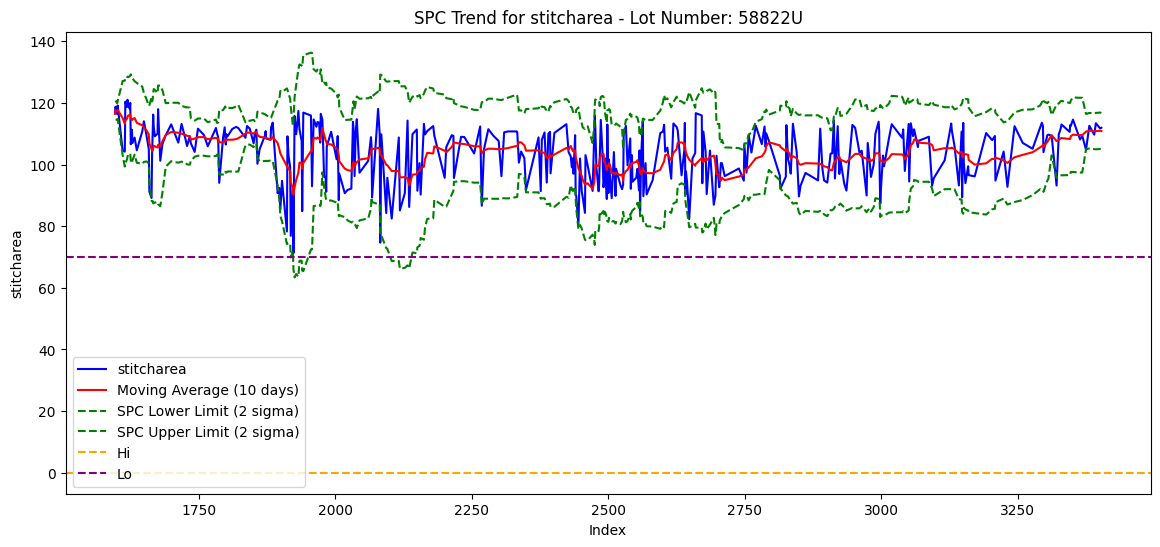

C:\Users\ovadir2\AppData\Local\Temp\ipykernel_19984\1582438294.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  display_scd_anomaly(scd_anomaly).show()


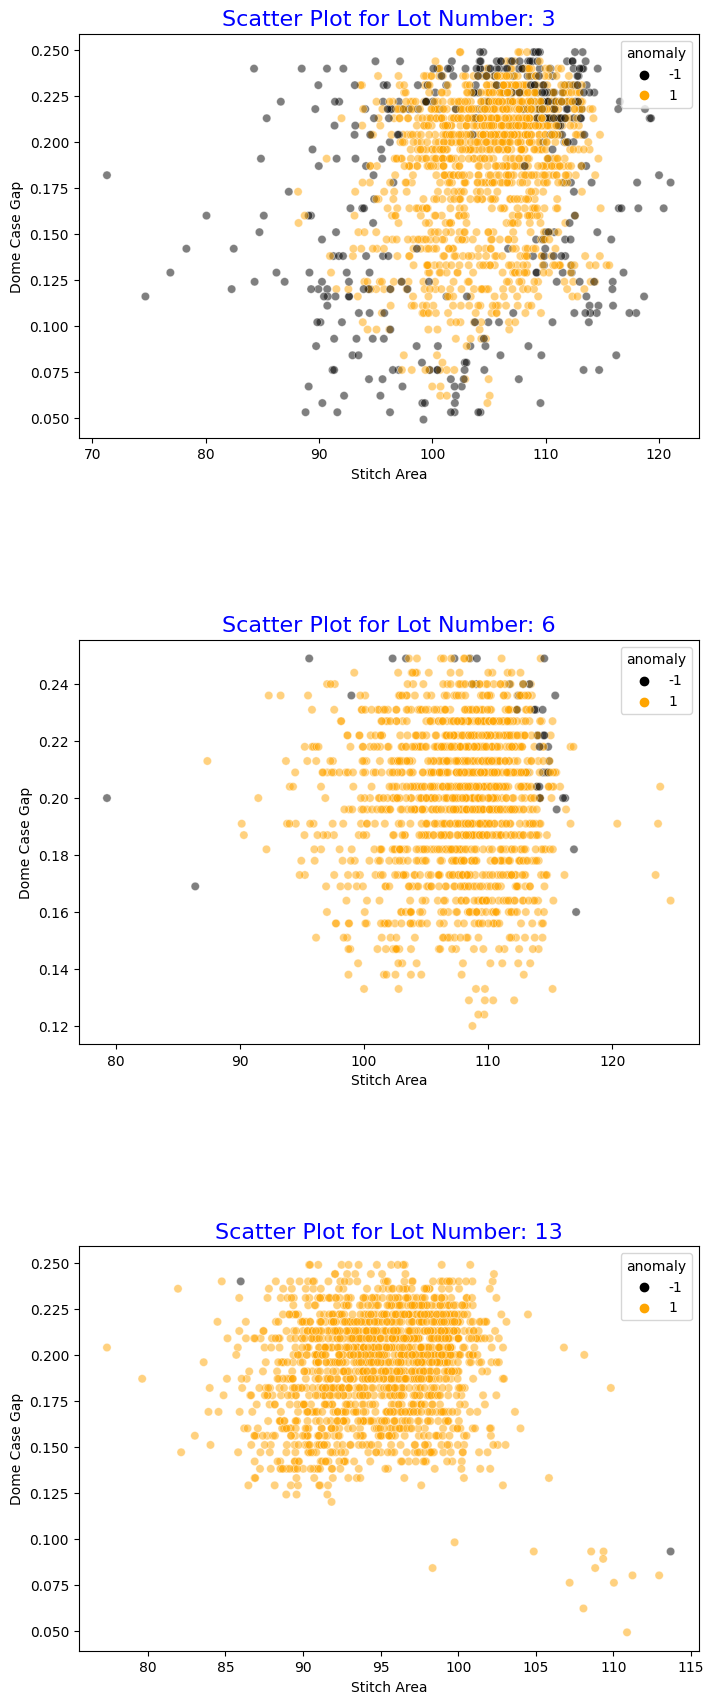

In [155]:
anomaly_kpi = {}
scd_only_anomaly = scd_anomaly[scd_anomaly['anomaly'] == -1]
scd_only_nomaly = scd_anomaly[scd_anomaly['anomaly'] != -1]
features = ["domecasegap", "stitcharea"]

for feature in features:
    anomaly_kpi = display_anomaly_kpi(scd_anomaly, scd_refine, feature)
    print(f"Anomaly KPIs for {feature}:")
    for kpi_name, kpi_value in anomaly_kpi.items():
        if kpi_name != 'limit_feature':
            print(f"{kpi_name}: {kpi_value}")
            limit_feature = anomaly_kpi.get('limit_feature', {})
            lo_avg = limit_feature.get('lo_avg')
            hi_avg = limit_feature.get('hi_avg')

# Display the trend plot
scd_only_anomaly_trend = plot_spc_trend(scd_refine,anomaly_kpi, feature, window_size=10, sigma=2)
# Display the anomaly plot
display_scd_anomaly(scd_anomaly).show()
        

#### Moving average prediction

In [57]:
# def spc_trend_alarm(actual, lo, hi):
#     spc_lo = actual * 0.8  # Lower SPC limit
#     spc_hi = actual * 1.2  # Upper SPC limit

#     if lo < spc_lo and hi > spc_hi:
#         trend = "Within SPC limits"
#         alarm = "No Alarm"
#     elif lo >= spc_lo and hi <= spc_hi:
#         trend = "Approaching SPC limits"
#         alarm = "No Alarm"
#     elif lo < spc_lo:
#         trend = "Below SPC limits"
#         alarm = "Low Alarm"
#     elif hi > spc_hi:
#         trend = "Above SPC limits"
#         alarm = "High Alarm"
#     else:
#         trend = "Unknown"
#         alarm = "Unknown"

#     return trend, alarm

In [17]:
# #light learn
# !pip install -q ipywidgets
# !pip install -q litelearn
# import litelearn

In [36]:
# df_model = scd_only_anomaly_trend
# display(df_model.head(5))
# df_model.dropna(subset=['MA'], inplace=True)
# df_model.dropna(subset=['STD'], inplace=True)
# train = df_model[:1000]
# validation = df_model[1000:]
# pred_model = litelearn.core_regress_df(train, 'MA' );#drop_columns=['TesterPhaseName', 'CapsuleTypeName', 'TesterType','Blister_Id', 'PASS_FAILED','ERROR_Code_Description', 'Date', 'Start_Time', 'End_time','BatchPath', 'Shift'])pred_model = litelearn.core_regress_df(train, 'MA' );#drop_columns=['TesterPhaseName', 'CapsuleTypeName', 'TesterType','Blister_Id', 'PASS_FAILED','ERROR_Code_Description', 'Date', 'Start_Time', 'End_time','BatchPath', 'Shift'])
# pred_mode2 = litelearn.core_regress_df(train, 'STD' );#drop_columns=['TesterPhaseName', 'CapsuleTypeName', 'TesterType','Blister_Id', 'PASS_FAILED','ERROR_Code_Description', 'Date', 'Start_Time', 'End_time','BatchPath', 'Shift'])pred_model = litelearn.core_regress_df(train, 'MA' );#drop_columns=['TesterPhaseName', 'CapsuleTypeName', 'TesterType','Blister_Id', 'PASS_FAILED','ERROR_Code_Description', 'Date', 'Start_Time', 'End_time','BatchPath', 'Shift'])
# df_model = df_model.reset_index(drop=True)
# pred_model.display_shap()
# pred_mode2.display_shap()


In [37]:
# pred_model.display_shap()

In [150]:

df = scd_only_anomaly_trend.copy()

# Drop rows with NaN values
df = df.dropna()

# Prepare the input features (X) and target variables (y)
X = df[['week', 'domecasegap', 'stitcharea', 'test_time_sec']]
y_ma = df['MA']
y_std = df['STD']

# Split the data into training and testing sets
X_train, X_test, y_ma_train, y_ma_test, y_std_train, y_std_test = train_test_split(X, y_ma, y_std, test_size=0.2, random_state=42)

# Train a linear regression model for MA
ma_model = LinearRegression()
ma_model.fit(X_train, y_ma_train)

# Predict MA values for the testing set
y_ma_pred = ma_model.predict(X_test)

# Train a linear regression model for STD
std_model = LinearRegression()
std_model.fit(X_train, y_std_train)

# Predict STD values for the testing set
y_std_pred = std_model.predict(X_test)

# Evaluate the performance of the models
ma_mse = mean_squared_error(y_ma_test, y_ma_pred)
std_mse = mean_squared_error(y_std_test, y_std_pred)

print(f"MA MSE: {ma_mse}")
print(f"STD MSE: {std_mse}")


KeyError: 'MA'

In [141]:

df = scd_only_anomaly_trend.copy()
display(df)

# # Drop rows with NaN values
# df = df.dropna()

# Prepare the input features (X) and target variables (y)
X = df[['week', 'domecasegap', 'stitcharea', 'test_time_sec']]
y_ma = df['MA']
y_std = df['STD']
# Group the dataframe by 'week'
grouped_df = df.groupby('week')

# Initialize lists to store predicted and actual values
y_ma_pred = []
y_ma_test = []
y_std_pred = []
y_std_test = []
print(len(grouped_df))
if len(grouped_df) >20 :
    # Iterate over each week group
    for week, group in grouped_df:
        # Split the data into training and testing sets
        X_train, X_test, y_ma_train, y_ma_test_curr, y_std_train, y_std_test_curr = train_test_split(
            group[['week', 'domecasegap', 'stitcharea', 'test_time_sec']],
            group['MA'],
            group['STD'],
            test_size=0.2,
            random_state=42
        )

        # Train a linear regression model for MA
        ma_model = LinearRegression()
        ma_model.fit(X_train, y_ma_train)

        # Predict MA values for the testing set
        y_ma_pred_curr = ma_model.predict(X_test)

        # Train a linear regression model for STD
        std_model = LinearRegression()
        std_model.fit(X_train, y_std_train)

        # Predict STD values for the testing set
        y_std_pred_curr = std_model.predict(X_test)

        # Append the predicted and actual values to the respective lists
        y_ma_pred.extend(y_ma_pred_curr)
        y_ma_test.extend(y_ma_test_curr)
        y_std_pred.extend(y_std_pred_curr)
        y_std_test.extend(y_std_test_curr)

    # Convert the lists to numpy arrays
    y_ma_pred = np.array(y_ma_pred)
    y_ma_test = np.array(y_ma_test)
    y_std_pred = np.array(y_std_pred)
    y_std_test = np.array(y_std_test)

    # Evaluate the performance of the models
    ma_mse = mean_squared_error(y_ma_test, y_ma_pred)
    std_mse = mean_squared_error(y_std_test, y_std_pred)

    print(f"MA MSE: {ma_mse}")
    print(f"STD MSE: {std_mse}")
    
    # Calculate the predicted CaseDomeGap using the predicted MA and STD values
    predicted_case_dome_gap = y_ma_pred + 2* y_std_pred

    # Calculate the SPC limits for CaseDomeGap
    spc_lower_limit = df['SPC_Lower'].mean()
    spc_upper_limit = df['SPC_Upper'].mean()
    print(predicted_case_dome_gap)
    # Compare the predicted CaseDomeGap to the SPC limits
    for i in range(len(predicted_case_dome_gap)):
        if predicted_case_dome_gap[i] < spc_lower_limit or predicted_case_dome_gap[i] > spc_upper_limit:
            print(f"Alarm: Predicted CaseDomeGap {predicted_case_dome_gap[i]} is out of SPC limits")
        else:
            print(f"No Alarm: Predicted CaseDomeGap {predicted_case_dome_gap[i]} is within SPC limits")
else:
    print('need to have more data for prediction model trainning....')


{'58822U':       week  batchid  batchid  tp_cell_name blister_id  domecasegap  \
 1596     1   925050   925050          11.0                   0.222   
 1597     1   925050   925050          11.0                   0.218   
 1600     1   925050   925050          11.0                   0.218   
 1601     1   925050   925050          11.0                   0.213   
 1610     1   925050   925050          11.0                   0.222   
 ...    ...      ...      ...           ...        ...          ...   
 3381     1   925056   925056          12.0    MWY7SG4        0.249   
 3390     1   925056   925056          12.0    MBD8SHQ        0.227   
 3393     1   925056   925056          12.0    5QC8SH3        0.204   
 3401     1   925056   925056          12.0    56B8SH9        0.213   
 3403     1   925056   925056          11.0    VWY7SGC        0.200   
 
      domecasegap_limit domecasegap_spc  stitcharea stitcharea_limit  \
 1596             :0.25   0.1776:0.2664     116.545             

TypeError: unhashable type: 'list'

In [25]:
# # Calculate the predicted CaseDomeGap using the predicted MA and STD values
# predicted_case_dome_gap = y_ma_pred + 2* y_std_pred

# # Calculate the SPC limits for CaseDomeGap
# spc_lower_limit = df['SPC_Lower'].mean()
# spc_upper_limit = df['SPC_Upper'].mean()
# print(predicted_case_dome_gap)
# # Compare the predicted CaseDomeGap to the SPC limits
# for i in range(len(predicted_case_dome_gap)):
#     if predicted_case_dome_gap[i] < spc_lower_limit or predicted_case_dome_gap[i] > spc_upper_limit:
#         print(f"Alarm: Predicted CaseDomeGap {predicted_case_dome_gap[i]} is out of SPC limits")
#     else:
#         print(f"No Alarm: Predicted CaseDomeGap {predicted_case_dome_gap[i]} is within SPC limits")


[]


In [25]:

# class MA_STD_Predictor:
#     def __init__(self, ma_upper_threshold, std_upper_threshold):
#         self.ma_model = None
#         self.std_model = None
#         self.ma_upper_threshold = ma_upper_threshold
#         self.std_upper_threshold = std_upper_threshold
    
#     def train(self, X_train, y_ma_train, y_std_train):
#         # Train a linear regression model for MA
#         self.ma_model = LinearRegression()
#         self.ma_model.fit(X_train, y_ma_train)
        
#         # Train a linear regression model for STD
#         self.std_model = LinearRegression()
#         self.std_model.fit(X_train, y_std_train)
    
#     def predict(self, X):
#         # Predict MA values
#         y_ma_pred = self.ma_model.predict(X)
        
#         # Predict STD values
#         y_std_pred = self.std_model.predict(X)
        
#         return y_ma_pred, y_std_pred
    
#     def check_alarms(self, y_ma_pred, y_std_pred):
#         # Check for alarms
#         ma_alarms = y_ma_pred > self.ma_upper_threshold
#         std_alarms = y_std_pred > self.std_upper_threshold
        
#         return ma_alarms, std_alarms

# # Load the data and preprocess if necessary
# df = scd_only_anomaly_trend.copy()
# # Drop rows with NaN values
# df = df.dropna()

# # Group the data by week and aggregate the features
# df_grouped = df.groupby("week").agg({
#     "domecasegap": "mean",
#     "stitcharea": "mean",
#     "test_time_sec": "mean",
#     "MA": "mean",
#     "STD": "mean"
# }).reset_index()

# # Prepare the input features (X) and target variables (y)
# X = df_grouped[['week', 'domecasegap', 'stitcharea', 'test_time_sec']]
# y_ma = df_grouped['MA']
# y_std = df_grouped['STD']

# # Create an instance of the MA_STD_Predictor class
# ma_upper_threshold = 115.0
# std_upper_threshold = 10.0
# predictor = MA_STD_Predictor(ma_upper_threshold, std_upper_threshold)

# # Train the models
# predictor.train(X, y_ma, y_std)

# # Make predictions
# y_ma_pred, y_std_pred = predictor.predict(X)

# # Evaluate the performance of the models
# ma_mse = mean_squared_error(y_ma, y_ma_pred)
# std_mse = mean_squared_error(y_std, y_std_pred)

# print(f"MA MSE: {ma_mse}")
# print(f"STD MSE: {std_mse}")

# # Check for alarms
# ma_alarms, std_alarms = predictor.check_alarms(y_ma_pred, y_std_pred)

# # Print the alarms
# print("MA Alarms:")
# print(df_grouped.loc[ma_alarms, ['week', 'MA']])
# print("\nSTD Alarms:")
# print(df_grouped.loc[std_alarms, ['week', 'STD']])

# # Usage phase

# # Prepare input features for usage
# X_usage = pd.DataFrame({'week': ['2023-01-01'], 'domecasegap': [15.0], 'stitcharea': [250.0], 'test_time_sec': [300.0]})

# # Make predictions for usage
# y_ma_pred_usage, y_std_pred_usage = predictor.predict(X_usage)

# # Check for alarms in the usage predictions
# ma_alarms_usage, std_alarms_usage = predictor.check_alarms(y_ma_pred_usage, y_std_pred_usage)

# # Print the alarms in the usage predictions
# print("MA Alarms (Usage):")
# print(X_usage.loc[ma_alarms_usage, ['week']])
# print("\nSTD Alarms (Usage):")
# print(X_usage.loc[std_alarms_usage, ['week']])


In [74]:

# # Plotting MA
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(y_ma_test)), y_ma_test, label='Actual MA')
# plt.plot(range(len(y_ma_pred)), y_ma_pred, label='Predicted MA')
# plt.xlabel('Data Point')
# plt.ylabel('MA Value')
# plt.title('Actual vs Predicted MA')
# plt.legend()
# plt.show()

# # Plotting STD
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(y_std_test)), y_std_test, label='Actual STD')
# plt.plot(range(len(y_std_pred)), y_std_pred, label='Predicted STD')
# plt.xlabel('Data Point')
# plt.ylabel('STD Value')
# # plt.title('Actual vs Predicted STD')
# plt.legend()
# plt.show()


In [166]:
# # Define the year for which you want to iterate over the weeks
# def aggregate_yearly_weeks_raw_sc_data(yearly_df, year=2023):
#     # Get the current date and week number
#     current_date = datetime.datetime.now()
#     current_year = current_date.year
#     current_week = current_date.isocalendar()[1]

#     # Calculate the upper limit for the week range
#     if year > current_year:
#         upper_limit = current_week
#     elif year == current_year:
#         upper_limit = current_week if year == current_year else 52
#     else:
#         upper_limit = 52

#     # Calculate the number of additional weeks till today
#     if year < current_year:
#         additional_weeks = current_week
#     else:
#         additional_weeks = 0

#     for week in range(1, upper_limit + 1):
#         # Create the year week string
#         yearweek = f"{year}{week:02d}"

#         # Fetch the sealing data (917) for the current year week
#         scd_raw = fetch_sealing_data(year=year, yearweek=week, configs_id=917)
#         scd_anomaly, scd_refine = SealingCell_data_refinning(scd_raw)

#         # Check if the specified columns are present in the DataFrame
#         required_columns = ['domecasegap', 'stitcharea', 'test_time_sec']
#         if not set(required_columns).issubset(scd_anomaly.columns):
#             print(f"Skipping week {week} of year {year} - Required columns not found in scd_anomaly DataFrame.")
#             continue

#         # Calculate the mean for specific columns
#         mean_values = scd_anomaly[required_columns].mean()

#         # Create a new DataFrame with the mean values
#         aggregated_row = pd.DataFrame([mean_values], columns=mean_values.index)

#         # Append the aggregated row to the yearly dataframe
#         yearly_df = pd.concat([yearly_df, aggregated_row], ignore_index=True)

#     # Append additional weeks till today if applicable
#     for additional_week in range(1, additional_weeks + 1):
#         yearweek = f"{current_year}{additional_week:02d}"
#         scd_raw = fetch_sealing_data(year=current_year, yearweek=additional_week, configs_id=917)
#         scd_anomaly, scd_refine = SealingCell_data_refinning(scd_raw)

#         # Check if the specified columns are present in the DataFrame
#         required_columns = ['domecasegap', 'stitcharea', 'test_time_sec']
#         if not set(required_columns).issubset(scd_anomaly.columns):
#             print(f"Skipping additional week {additional_week} of current year - Required columns not found in scd_anomaly DataFrame.")
#             continue

#         # Calculate the mean for specific columns
#         mean_values = scd_anomaly[required_columns].mean()

#         # Create a new DataFrame with the mean values
#         aggregated_row = pd.DataFrame([mean_values], columns=mean_values.index)

#         # Append the aggregated row to the yearly dataframe
#         yearly_df = pd.concat([yearly_df, aggregated_row], ignore_index=True)

#     return yearly_df


In [167]:
# # Get the current date and week number
# scd_weeks_raws = pd.DataFrame()
# scd_weeks_raws = aggregate_yearly_weeks_raw_sc_data(scd_weeks_raws, year=2022)


In [75]:
# display(scd_weeks_raws)
# scd_weeks_raws_anamoly = check_anomalies(scd_weeks_raws, contamination=0.05, n_estimators=100)

In [24]:

# ###Main
# agregate_yearly_weeks_raw_sc_data= agregate_yearly_weeks_raw_sc_data(year=2023)

# scd_anomaly,scd_refine =SealingCell_data_refinning(scd_raw)
# display(scd_anomaly)
# display(scd_refine)
# #Adjust the contamination value and number of estimators
# scd_anomaly_check = pd.DataFrame()
# scd_anomaly_check= check_anomalies(scd_anomaly, contamination=0.05, n_estimators=100);
# anomaly_kpi = {}
# scd_only_anomaly = scd_anomaly[scd_anomaly['anomaly'] == -1]
# scd_only_nomaly = scd_anomaly[scd_anomaly['anomaly'] != -1]
# features = ["domecasegap", "stitcharea"]

# for feature in features:
#     anomaly_kpi = display_anomaly_kpi(scd_anomaly, scd_refine, feature)
#     print(f"Anomaly KPIs for {feature}:")
#     for kpi_name, kpi_value in anomaly_kpi.items():
#         if kpi_name != 'limit_feature':
#             print(f"{kpi_name}: {kpi_value}")
#     limit_feature = anomaly_kpi.get('limit_feature', {})
#     lo_avg = limit_feature.get('lo_avg')
#     hi_avg = limit_feature.get('hi_avg')
#     # Display the trend plot
#     plot_spc_trend(scd_only_anomaly, feature, window_size=10, sigma=2, hi_avg=hi_avg, lo_avg=lo_avg)

# # Display the anomaly plot
# display_scd_anomaly(scd_anomaly)
        


In [76]:
# import pandas as pd

# def generate_moving_average(scd_raw, feature, window_size=7):
#     # Convert 'test_time_sec' column to datetime format
#     scd_raw['test_time_sec'] = pd.to_datetime(scd_raw['test_time_sec'], unit='s')
    
#     # Set 'test_time_sec' as the DataFrame index
#     scd_raw.set_index('test_time_sec', inplace=True)
    
#     # Resample data to weekly level
#     scd_weekly = scd_raw[feature].resample('W').mean()
    
#     # Compute the moving average
#     scd_weekly['moving_average'] = scd_weekly.rolling(window=window_size).mean()
    
#     return scd_weekly


In [77]:
# scd_raw = fetch_sealing_data(year=2023, quarter=None, month=None, yearweek=23, weekday=None, configs_id=917)
# display()
# scd_weekly = generate_moving_average(scd_raw, 'domecasegap', window_size=7)

### Data Ingestion:

#### Kafka Producer:


### Real-time Processing:

#### Kafka Consumer:
- Consume the sensor data from Kafka topics.
- Apply anomaly detection and compare to limts; to identify anomalies in real-time.
- Generate anomaly alerts and notifications.
- Store the processed data and anomaly results in a data store (such as a database or data lake) for further analysis.

## Data Storage:

####  Hive and HDFS:
- Store the raw sensor data, processed data, anomaly results, anomaly thresholds, and predicted values.
- Store the processed and aggregated data.
- Create Hive tables or data structures for efficient querying.

## User Interface and Reporting:

#### Streamlit or Web Application:
- Develop a user interface to visualize real-time and historical sensor data.
- Display anomaly alerts, trends, and predictions.
- Provide interactive features for data exploration and analysis.
- Enable users to set and modify anomaly thresholds and prediction models.

## Workflow Orchestration:

#### Airflow:
- Schedule and manage the execution of data ingestion, real-time processing, batch processing, and reporting tasks.
- Define workflows to ensure timely execution and data consistency.
- Handle error handling, retries, and monitoring of task execution.


In [8]:
# def Get_sealing_raw_bt_date():
    
#     #build factory data directory dictionary by station
#     csv_files = glob.glob(path_Sap_station+'*.{}'.format('csv')) #list all csv files only
#     dict_sap_by_station ={}        

#     for station_file in csv_files:
#         path =station_file.split('\\')

#         station = path[-1].split('.')[0][:-7]
#         station_lot = path[-1].split('_')[-1][:-4]

#         if station not in dict_sap_by_station.keys():         # or dict.keys() for better readability (but is the same)
#             dict_sap_by_station[station] = [station_lot]
#         else:
#             dict_sap_by_station[station].append(station_lot)

#     print(dict_sap_by_station)
#     return(dict_sap_by_station)


In [7]:

# def write_csv_to_hdfs(dataframe, hdfs_path):
# import os
# import pyarrow as pa

# fs = pa.hdfs.connect(
#     host='localhost',
#     port=8020,
#     user='hdfs',
#     kerb_ticket=None,
#     extra_conf=None)

# cap = pa.hdfs.HadoopFileSystem.get_capacity(fs)

# print(str(round(cap / pow(1024,2), 0)) + ' MB')

# ###@@@@@@@@@@@@@@@@@@@@

#     hdfs_client = InsecureClient('http://hdfs-namenode:9870', user='hdfs')
#     with hdfs_client.write(hdfs_path) as file:
#         dataframe.to_csv(file, index=False)
#     print(f"CSV file written to HDFS: {hdfs_path}")


In [3]:
 
# def write_stations_hdfs():
#         all_station_lots_dfs = []
#         dict_sap_by_station = dict_sap_by_station_()
#         stations = ['SealingCell']

#         for station,lots in dict_sap_by_station.items():
#             df2 = pd.DataFrame()  # create a new dataframe for each key
#             for lot in lots:
#                 for anomaly_station in stations:
#                     try:
#                         station_path = path_Sap_station+anomaly_station+'_'+lot+'.csv'
#                         df_anomaly_station = pd.read_csv(station_path)
#                         #skiping empty input file
#                         if not df_anomaly_station.empty:
#                             write_csv_to_hdfs(df_anomaly_station,hdfs_path)
#                         else:
#                             print('Found empty file :', station_path) 
#                     except AttributeError as e:
#                         #Handling the AttributeError
#                         print(f"AttributeError occurred {station_path} in main: {e}")  
#                         return(False)
#                     except TypeError as e:
#                         #Handling the TypeError
#                         print(f"TypeError occurred {station_path} in main: {e}")
#                         return(False)
#             print('=======================================')
#             print('all Lots per station ......completed   ')
#             print('=======================================')
#             return(True)

In [1]:
# path_Sap_station = '.\\Projects_Sources\\'
# hdfs_path = '.\\Projects_Sources\\Output\\anomaly'
# product_pn = 'ASM-0486-01'
# line_name = 'HPL_SB3'
# df_excel_lines_parse = pd.DataFrame()
# stations_list=[]

# result = write_stations_hdfs()
# print(result)

### fetch data detectors

In [ ]:
# import requests
# # Set the server URL
# url = 'http://localhost:8000/SealingCell_data'

# # Set the path to the CSV file in Collab
# _filter = 'C:\\Python3102\\Projects_Sources\\SealingCell_57436U.csv'

# try:
#     # Make the GET request to the server
#     response = requests.post(url, params={'path': path})
#     response.raise_for_status()  # Raise an exception for non-2xx response codes

#     # Get the response data (JSON)
#     result = response.json()
#     print(result)  # Print JSON response

# except requests.exceptions.RequestException as e:
#     print('Error sending request:', str(e))

In [2]:
# import requests
# # Set the server URL
# url = 'http://localhost:8000/SealingCell_data'

# # Set the path to the CSV file in Collab
# path = 'C:\\Python3102\\Projects_Sources\\SealingCell_57436U.csv'

# try:
#     # Make the GET request to the server
#     response = requests.post(url, params={'path': path})
#     response.raise_for_status()  # Raise an exception for non-2xx response codes

#     # Get the response data (JSON)
#     result = response.json()
#     print(result)  # Print JSON response

# except requests.exceptions.RequestException as e:
#     print('Error sending request:', str(e))

## Anomaly test

In [6]:
from sklearn.ensemble import IsolationForest

# Convert the result dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(result['lotnumber'])
display(df)
# Assign feature names to the DataFrame columns
df.columns = ['blisterid', 'domecasegap', 'stitcharea', 'testtimemin','testtimesec', 'material']

# Select the features you want to perform anomaly detection on
features = ['testtimesec']

# Create a subset of the data with the selected features
X = df[features]

# Handle missing values by replacing them with a specific value (e.g., -999)
X = X.fillna(-999)

# Initialize the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.015)

# Fit the model to the data
isolation_forest.fit(X)


# Predict the anomalies in the data
df['anomaly'] = isolation_forest.predict(X)

# Print out the anomaly records
df[df['anomaly']==-1]

# Print the anomalies
anomalies = df[df['anomaly'] == -1]
display(anomalies)


,blisterid,domecasegap,stitcharea,testtimemin,testtimesec,material
0,DUV4AHD,0.213,108.346,00:18,1080,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
1,5YUMBGU,0.213,115.913,00:23,1380,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
2,D2H4SGS,0.191,110.335,00:19,1140,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
3,VEH4SGD,0.227,112.413,00:17,1020,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
4,V6V4AHA,0.173,100.511,00:19,1140,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
...,...,...,...,...,...,...
1897,MUXNDCL,0.191,109.918,00:18,1080,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
1898,5TYPTF9,0.204,110.152,00:24,1440,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
1899,DF5JDD6,0.204,104.992,00:17,1020,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
1900,MDAMUAF,0.204,109.651,00:18,1080,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...


C:\Python3102\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,blisterid,domecasegap,stitcharea,testtimemin,testtimesec,material,anomaly
59,58H4SGY,0.173,91.427,00:20,1200,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
198,5ZK5AJA,0.222,108.764,00:22,1320,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
200,52K5AJY,0.187,96.345,00:27,1620,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
243,5Q3JDDB,0.182,109.079,00:15,900,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
565,MQXPTFX,0.209,106.873,00:15,900,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
584,VV7LUAG,0.218,99.459,00:22,1320,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
664,VFW4AHL,0.200,112.132,00:20,1200,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
686,5YH4SG5,0.204,108.760,00:15,900,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
834,538LUA9,0.178,102.705,00:15,900,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1
878,M5XPTF8,0.204,108.604,00:14,840,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...,-1


## Plot

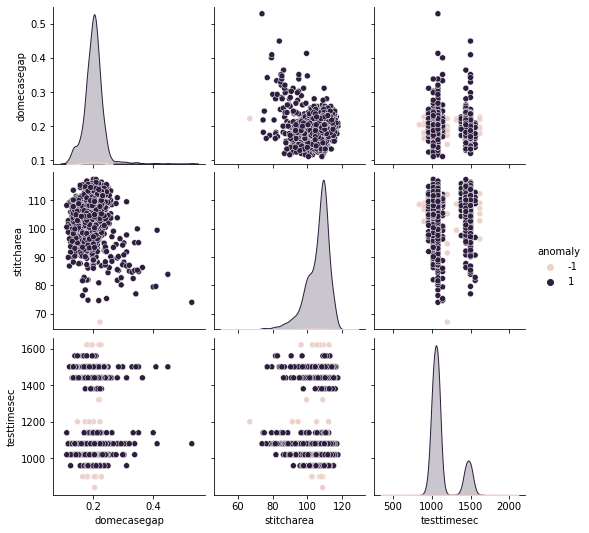

In [7]:
import seaborn as sns

df2 = pd.concat([df[df.anomaly==-1], df[df.anomaly != -1] ])#.sample(1000)])
sns.pairplot(df2, hue='anomaly')  

## prediction

In [27]:
!pip install litelearn

In [34]:
#need to predict week ahead
# agrigate 7 days ahead 
# predict DomeCaseGap

path = 'C:\\Python3102\\Projects_Sources\\SealingCell_57436U.csv'
df = pd.DataFrame.from_dict(result['lotnumber'])
display(df)
# Assign feature names to the DataFrame columns
df.columns = ['blisterid', 'domecasegap', 'stitcharea', 'testtimemin','testtimesec', 'material']

df_model = df
df_model.dropna(subset=['domecasegap'], inplace=True)
df_model.dropna(subset=['blisterid'], inplace=True)
train = df_model[:1000]
validation = df_model[1000:]


,blisterid,domecasegap,stitcharea,testtimemin,testtimesec,material
0,DUV4AHD,0.213,108.346,00:18,1080,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
1,5YUMBGU,0.213,115.913,00:23,1380,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
2,D2H4SGS,0.191,110.335,00:19,1140,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
3,VEH4SGD,0.227,112.413,00:17,1020,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
4,V6V4AHA,0.173,100.511,00:19,1140,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
...,...,...,...,...,...,...
1897,MUXNDCL,0.191,109.918,00:18,1080,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
1898,5TYPTF9,0.204,110.152,00:24,1440,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
1899,DF5JDD6,0.204,104.992,00:17,1020,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...
1900,MDAMUAF,0.204,109.651,00:18,1080,220717_SB3-AFR-U_SealingCell_FTEST_57436U_MR_1...


In [40]:
import litelearn 
#pred_model = litelearn.core_regress_df(train, 'DomeCaseGap', drop_columns=['TesterPhaseName', 'Test_Time_min' 'CapsuleTypeName', 'TesterType','Blister_Id', 'PASS_FAILED','ERROR_Code_Description', 'Date', 'Start_Time', 'End_time','BatchPath', 'Shift'])
pred_model = litelearn.core_regress_df(train, 'domecasegap',drop_columns=['testtimemin'])

casting blisterid onto category
casting testtimemin onto category
casting material onto category
None
using categories: ['blisterid', 'material']


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.048148
0:	learn: 0.0294367	test: 0.0329182	best: 0.0329182 (0)	total: 55ms	remaining: 54.9s
1:	learn: 0.0293208	test: 0.0327429	best: 0.0327429 (1)	total: 97.6ms	remaining: 48.7s
2:	learn: 0.0291576	test: 0.0326129	best: 0.0326129 (2)	total: 151ms	remaining: 50.2s
3:	learn: 0.0290344	test: 0.0324636	best: 0.0324636 (3)	total: 192ms	remaining: 47.8s
4:	learn: 0.0288907	test: 0.0323170	best: 0.0323170 (4)	total: 245ms	remaining: 48.7s
5:	learn: 0.0287664	test: 0.0321846	best: 0.0321846 (5)	total: 297ms	remaining: 49.3s
6:	learn: 0.0286335	test: 0.0320007	best: 0.0320007 (6)	total: 351ms	remaining: 49.8s
7:	learn: 0.0285130	test: 0.0318680	best: 0.0318680 (7)	total: 411ms	remaining: 50.9s
8:	learn: 0.0284141	test: 0.0317086	best: 0.0317086 (8)	total: 463ms	remaining: 51s
9:	learn: 0.0283301	test: 0.0316629	best: 0.0316629 (9)	total: 515ms	remaining: 51s
10:	learn: 0.0282407	test: 0.0315820	best: 0.0315820 (10)	total: 565ms	remaining: 50.8s
11:	learn: 0.0281769	test:

,rmse,support
train,0.024444,700
test,0.027879,300


,Feature Id,Importances
0,stitcharea,78.980457
1,testtimesec,21.019543
2,blisterid,0.000000
3,material,0.000000


## save the model

In [89]:
import pickle
with open('C:\\Python3102\\Projects_Sources\\models\\anomaly_welding_gap.pickle', 'wb') as f:
    pickle.dump(isolation_forest, f)

In [90]:
with open('C:\\Python3102\\Projects_Sources\\models\\anomaly_welding_gap.pickle', 'rb') as f2:
    my_model = pickle.load(f2)


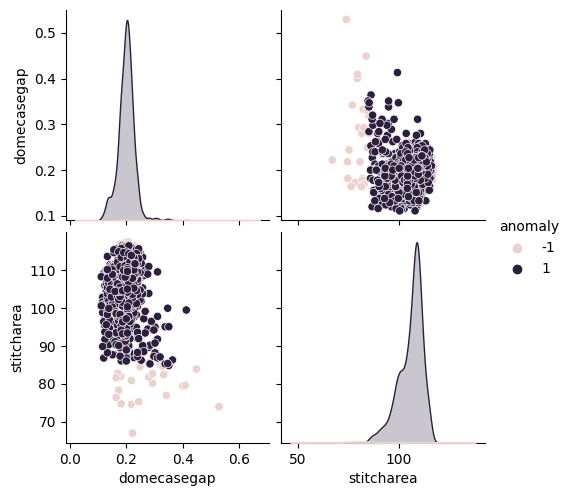

In [103]:
# Predict the anomalies in the data
df['anomaly'] = my_model.predict(X)

# Print out the anomaly records
df[df['anomaly']==-1]

# Print the anomalies
anomalies = df[df['anomaly'] == -1]
df2 = pd.concat([anomalies, df[df['anomaly'] != -1]])#.sample(1000)])
sns.pairplot(df2, hue='anomaly')  

# Visualization

In [23]:
!pip install -q streamlit
!pip install -q streamlit_shap

In [24]:
import glob
import seaborn as sns
import streamlit as st
import requests
import pandas as pd
import json
import pickle
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import warnings


@st.cache_data()
def fetch_data_from_api(url, path):
    try:
        # Make the GET request to the server
        response = requests.post(url, params={'path': path})
        st.write(response)
        response.raise_for_status()  # Raise an exception for non-2xx response codes
        # Get the response data (JSON)
        result = response.json()
        return result

    except requests.exceptions.RequestException as e:
        print('Error sending request:', str(e))
        st.write('Error sending request:', str(e))
        return(str(e))

def predict_anomalies(data, feature,contamination_val):
    try:
        # Convert the result dictionary to a pandas DataFrame
        df = pd.DataFrame.from_dict(data['lotnumber'])
        # Assign feature names to the DataFrame columns
        df.columns = ['blisterid', 'domecasegap', 'stitcharea', 'testtimemin','testtimesec','material']
        # Create a subset of the data with the selected features
        X = df[feature]
 
        # Handle missing values by replacing them with a specific value (e.g., -999)
        X = X.fillna(-999)

        # Create the Isolation Forest model with the selected contamination value
        isolation_forest = IsolationForest(contamination=contamination_val)

        # Display the selected contamination value
        st.write("Selected Contamination Value:", f"{contamination_val:.3f}")

        # Fit the model to the data
        isolation_forest.fit(X)
        # Predict the anomalies in the data
        df['anomaly'] = isolation_forest.predict(X)
        return df
    except (ValueError, TypeError, AttributeError) as e:
        st.write(str(e))
        return(str(e))

def display_anomaly_evaluation(df,feature):
    try:
 
        if (feature == 'domecasegap') :
            ratio_ = len( df[df['anomaly'] == -1])  / len(df[df['anomaly'] != -1]) 
            amount = len( df[df['anomaly'] == -1])  
            mean_gap = df[df['anomaly'] == -1]['domecasegap'].mean() 
            mean_gap_good = df[df['anomaly'] != -1]['domecasegap'].mean() 
            # Create a two-column layout
            col1, col2, col3 = st.columns(3)
            # Display the metrics in each column
            with col1:
                st.metric(label="Gap Amount (Anomal/Nomal)", value=f'{ratio_:.2%}', delta_color='inverse')
                st.write('<style>div[data-baseweb="metric"] {font-size: small;}</style>', unsafe_allow_html=True)
            with col2:
                st.metric(label="Gap Amount ", value=f'{amount}', delta_color='inverse')
                st.write('<style>div[data-baseweb="metric"] {font-size: small;}</style>', unsafe_allow_html=True)
            with col3:
                st.metric(label="Mean Gap(Anomal/Nomal)", value=f'{mean_gap:.2f}', delta=f'{mean_gap / mean_gap_good:.2%}')
                st.write('<style>div[data-baseweb="metric"] {font-size: small;}</style>', unsafe_allow_html=True)


        if (feature == 'testtimesec') :
            ratio_ = len( df[df['anomaly'] == -1])  / len(df[df['anomaly'] != -1]) 
            amount = len( df[df['anomaly'] == -1])  
            mean_testtimesec = df[df['anomaly'] == -1]['testtimesec'].mean() 
            mean_testtimesec_good = df[df['anomaly'] != -1]['testtimesec'].mean() 
           # Create a two-column layout
            col1, col2, col3 = st.columns(3)
            # Display the metrics in each column
            with col1:
                st.metric(label="Mean TestTimeSec ", value= f'{amount:.0f}' , delta_color='inverse')
            with col3:
                st.metric(label="Mean TestTimeSec(Anomal/Nomal)", value=f'{mean_testtimesec:.0f}', delta=f'{mean_testtimesec / mean_testtimesec_good:.2%}')
 
        if (feature == 'stitcharea') :
            ratio_ = len( df[df['anomaly'] == -1])  / len(df[df['anomaly'] != -1]) 
            amount = len( df[df['anomaly'] == -1])  
            mean_stitch = df[df['anomaly'] == -1]['stitcharea'].mean() 
            mean_stitch_good = df[df['anomaly'] != -1]['stitcharea'].mean() 
            # Create a two-column layout
            col1, col2,col3 = st.columns(3)
            # Display the metrics in each column
            # with col1:
            #     st.metric(label='StitchArea Amount (Anomal/Nomal)', value=f'{ratio_:.2%}', delta_color='inverse')
            # with col2:
            #     st.metric(label="StitchArea Amount", value=f'{amount:.0f}', delta_color='inverse')
            with col3:
                st.metric(label="Mean StitchArea(Anomal/Nomal)", value=f'{mean_stitch:.2f}', delta=f'{mean_stitch / mean_stitch_good:.2%}')
    except (ValueError, TypeError, AttributeError) as e:
        st.write(str(e))
        return(str(e))

             
def display_splot_anomaly(df):
    df2 = pd.concat([df[df.anomaly == -1], df[df.anomaly != -1]])
    g = sns.pairplot(df2, hue='anomaly')
    st.pyplot(g.fig)

def main():
    try:
        # Set the app title
        st.title("Welding Anomaly Detection")

        # Set the server URL
        server_url = "http://localhost:8000/SealingCell_data"

        # Display the file selection section
        st.subheader("File Selection")

        # Generate a unique identifier for the contamination slider
        slider_key = "contamination_slider"

         # Set the initial value for contamination
        default_contamination = 0.015

        # Create a slider widget to adjust the contamination value
        contamination_val = st.slider(
            "Contamination",
            min_value=0.001,
            max_value=0.02,
            value=default_contamination,
            step=0.002,
            key=slider_key,
            format="%.3f"
        )
         # Convert the contamination value to a float
        contamination_val = float(contamination_val)

        # Select the directory
        directory = st.text_input("Directory", r"C:\Python3102\Projects_Sources")

        # Set the file pattern
        #pattern = "SealingCell_*.csv"           ############@@@@@@@@@@@@@@@@@@@@@@@@@
        pattern = "SealingCell_59229U.csv"

        # Get the list of matching files
        files = glob.glob(f"{directory}/{pattern}")

        # Display the file selection dropdown
        selected_file = st.selectbox("Select a File", files)
        if selected_file:
            if st.button("Fetch Data"):
                # Fetch data from the API
                st.write(server_url,selected_file)
                data = fetch_data_from_api(server_url, selected_file)
                features = ["domecasegap","stitcharea","testtimesec"]
                if data:
                    for feature in features:                    
                        # Perform anomaly detection
                        df = predict_anomalies(data, features,contamination_val)

                        # Display evaluation and pairplot
                        display_anomaly_evaluation(df,feature)
                    display_splot_anomaly(df)
                else:
                    st.write('No sensor data')
   
    except (ValueError, TypeError, AttributeError) as e:
        print('ValueError:', str(e))

if __name__ == '__main__':
    main()



2023-05-26 16:12:54.824 No runtime found, using MemoryCacheStorageManager
